**Group information**

| Family name | First name | Email address |
| ----------- | ---------- | ------------- |
| Jiménez            | Blanca            | blancajimenez@bse.eu               |
| Fernández             | Pablo            | pablofernandeza@bse.eu               |

**Design Document**
Add your Design Document based on Lecture 1 below:


# Assignment_03_model_training_solution

Make sure to use a GPU and have access to internet connection in the Kaggle notebook:

1.  On the arrow on the bottom right, select "Notebook Options" and then "Accelerator" to choose the GPU P100, and select "Variables & Files" under Persistence. **Note that Kaggle allows 30h per week per user of accelerated computing. Plan your work accordingly. It takes time to load the data and you may experience unavailability of GPUs or Session Errors.**
1. Make sure your Kaggle account is phone verified by clicking "Get phone verified" in the left sidebar under "Notebook options" and following the steps (this step is required to switch on the internet connection needed to install packages). 
1. After phone verification, the full settings menu should be visible. Toggle the "Internet" switch.

More visualizations of the process to connect the notebook to the internet are provided [here](https://stackoverflow.com/questions/68142524/cannot-access-internet-on-kaggle-notebook)


## Requirements:

1. Downloading the tiles of the ecti2021 here: [ecti2021.zip](https://www.dropbox.com/scl/fi/tuvroadxyummourvx6cmz/ecti2021.zip?rlkey=wsc19sue84ytkphheptq28ica&st=9p8npaly&dl=0)
1. Go to the "Side Bar", Click on "Input"
1. Upload as `ecti2021` the file: `ecti2021.zip`  which contains the following four files: `train.zip`, `val_without_ref_labels.zip` , and the `water_tiles.csv` and `background_tiles.csv` from the `data_preparation.ipynb` notebook. 

# Step 0: Enviroment setting

In [1]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albu/albumentations --no-cache-di

In [ ]:
# load packages
import os
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from typing import List
import matplotlib.image as mpimg
import albumentations as A
from sklearn.metrics import confusion_matrix

# Set up plotting options
%matplotlib inline
import pickle
from pickle import load
import torch
from torch.utils.data import Dataset, DataLoader

NO_ALBUMENTATIONS_UPDATE=1

# Step 1: Load the dataset files

In [3]:
# Set path to where dataset is downloaded
dataset_root = '/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/' #set accordingly based on how you uploaded the data
# get number of training/validation regions
train_dir = os.path.join(dataset_root, 'train/train')
test_dir = os.path.join(dataset_root, 'val_without_ref_labels/val')

n_train_regions = len(glob(train_dir+'/*/'))
n_test_regions = len(glob(test_dir+'/*/'))

# NOTE: make sure number of regions is NOT 0, otherwise it might be that the code is not able to read the data. 
print('Number of training temporal-regions: {}'.format(n_train_regions))
print('Number of test temporal-regions: {}'.format(n_test_regions))

Number of training temporal-regions: 31
Number of test temporal-regions: 10


From the Lab_01_data_preparation, we identified that the ETCI 2021 Competition on Flood Detection is composed of 33'405 tiles. However, we also identified tiles that have empty VV/VH but have a non-zero label. We already excluded these tiles when saving the `water_tiles.csv` and `background_tiles.csv`. The dataset used in this notebook should contain 27'214 tiles. 

## Utils functions

In [4]:
def visualize(df_row, figsize=[25, 15]):
    # get image paths
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

    # create RGB image from S1 images
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

    # get water body label mask
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

    # plot images
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
        # plot RGB S1 image
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot water body mask
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0
        # plot RGB S1 image
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot flood label mask
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

        # plot water body mask
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')

def s1_to_rgb(vv_image, vh_image):
    eps=1e-06
    ratio_image = np.clip(np.nan_to_num(vv_image/(vh_image+eps), 0), 0, 1) # outside [0,1] will be clipped
    rgb_image = np.stack((vv_image, vh_image, ratio_image), axis=2) #different from lab01: np.abs(red) / np.abs(green) 
    return rgb_image

def visualize_result(df_row, prediction, figsize=[25, 15]):
    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
    rgb_input = s1_to_rgb(vv_image, vh_image)

    plt.figure(figsize=tuple(figsize))
    plt.subplot(1,2,1)
    plt.imshow(rgb_input)
    plt.title('RGB w/ result')
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title('Result')

# Step 2: Create training dataframes

In [5]:
def get_filename(filepath,split_symbol='/'):
    return filepath.split(split_symbol)[-1]

def read_csv(csvpath,split_symbol='\\'):
    path_list = np.loadtxt(csvpath,delimiter=" ", dtype=str).tolist()
    return [get_filename(pth,split_symbol) for pth in path_list]

In [6]:
water_image_names = read_csv(os.path.join(dataset_root, 'water_tiles.csv')) #from lab01 make sure the path is correct
background_image_names = read_csv(os.path.join(dataset_root, 'background_tiles.csv'))

region_name_dates0 = ['_'.join(n.split('_')[:2]) for n in water_image_names]
region_name_dates1 = ['_'.join(n.split('_')[:2]) for n in background_image_names]

vv_image_paths, vh_image_paths, flood_label_paths, water_body_label_paths = [], [], [], []


water_image_paths,background_image_paths = [],[]

for i in range(len(water_image_names)):
    vv_image_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'vv', water_image_names[i])
    vv_image_paths.append(vv_image_path)
    water_image_paths.append(vv_image_path)
    
    # get vh image path
    vh_image_name = water_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = water_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = water_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)
    
for i in range(len(background_image_names)):
    vv_image_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'vv', background_image_names[i])
    vv_image_paths.append(vv_image_path)
    background_image_paths.append(vv_image_path)
    
    # get vh image path
    vh_image_name = background_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = background_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = background_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)
    

In [7]:
#Shuffle the index and then split in train and validation
n=len(vv_image_paths) #number of images in the dataset
arr = np.arange(n) #array 0...n-1
np.random.shuffle(arr) # shuffle it
train_idx=arr[0:int(np.round(0.80*n))] #80% train
valid_idx=arr[int(np.round(0.80*n)):] #20% validation
print("Number of tiles in training set:",train_idx.size)
print("Number of tiles in validation set:",valid_idx.size)
print("Number of tiles in the training and validation set:",train_idx.size+valid_idx.size) 

Number of tiles in training set: 21771
Number of tiles in validation set: 5443
Number of tiles in the training and validation set: 27214


In [8]:
vv_image_paths_train = list(np.array(vv_image_paths)[train_idx])
vh_image_paths_train = list(np.array(vh_image_paths)[train_idx])
flood_label_paths_train = list(np.array(flood_label_paths)[train_idx])
water_body_label_paths_train = list(np.array(water_body_label_paths)[train_idx])

train_paths = {'vv_image_path': vv_image_paths_train,
        'vh_image_path': vh_image_paths_train,
        'flood_label_path': flood_label_paths_train,
        'water_body_label_path': water_body_label_paths_train,
}

train_df = pd.DataFrame(train_paths)

print('Training dataset:')
print(train_df.shape)
train_df.head()

Training dataset:
(21771, 4)


vv_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                       vh_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                    flood_label_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                               water_body_label_path  
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...

In [9]:
vv_image_paths_valid = list(np.array(vv_image_paths)[valid_idx])
vh_image_paths_valid = list(np.array(vh_image_paths)[valid_idx])
flood_label_paths_valid = list(np.array(flood_label_paths)[valid_idx])
water_body_label_paths_valid = list(np.array(water_body_label_paths)[valid_idx])

valid_paths = {'vv_image_path': vv_image_paths_valid,
        'vh_image_path': vh_image_paths_valid,
        'flood_label_path': flood_label_paths_valid,
        'water_body_label_path': water_body_label_paths_valid,
}

print('Validation dataset:')
valid_df = pd.DataFrame(valid_paths)

print(valid_df.shape)
valid_df.head()

Validation dataset:
(5443, 4)


vv_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                       vh_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                    flood_label_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                               water_body_label_path  
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...

## # Step 2b: Create training undersampled dataframes

In [11]:
background_image_paths_train = [path for path in background_image_paths if path in vv_image_paths_train]
background_num_train = len(background_image_paths_train)
print('Number of background tiles included in training:',background_num_train)

water_image_paths_train = [path for path in water_image_paths if path in vv_image_paths_train]
water_image_names_train = [get_filename(pth) for pth in water_image_paths_train]
region_name_dates2 = ['_'.join(n.split('_')[:2]) for n in water_image_names_train]
water_num_train = len(water_image_paths_train)
print('Number of water tiles included in training:',water_num_train)

Number of background tiles included in training: 13403
Number of water tiles included in training: 8368


In [12]:
num_samples = int(water_num_train * 0.15) #include 15% of water tiles
arr = np.arange(int(water_num_train * 0.15))  # array 0...n-1
np.random.shuffle(arr)  # shuffle it
background_image_paths_train_undersampled = list(np.array(background_image_paths_train)[arr[0:num_samples]])
background_image_names_train_undersampled = [get_filename(pth) for pth in background_image_paths_train_undersampled]
print('Number of background tiles included in training after undersampling:',len(background_image_names_train_undersampled))
region_name_dates3 = ['_'.join(n.split('_')[:2]) for n in background_image_names_train_undersampled]

vh_image_paths_train_undersampled, flood_label_paths_train_undersampled, water_body_label_paths_train_undersampled = [], [], []
for i in range(len(water_image_names_train)):
    # get vh image path
    vh_image_name = water_image_names_train[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates2[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths_train_undersampled.append(vh_image_path)

    # get flood mask path
    flood_image_name = water_image_names_train[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates2[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths_train_undersampled.append(flood_label_path)

    # get water body mask path
    water_body_label_name = water_image_names_train[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates2[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths_train_undersampled.append(water_body_label_path)

vv_image_paths_train_undersampled = water_image_paths_train
print('Number of water body label included in training after undersampling:',len(water_body_label_paths_train_undersampled))
for i in range(len(background_image_names_train_undersampled)):
    vv_image_paths_train_undersampled.append(background_image_paths_train_undersampled[i])
    
    # get vh image path
    vh_image_name = background_image_names_train_undersampled[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates3[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths_train_undersampled.append(vh_image_path)

    # get flood mask path
    flood_image_name = background_image_names_train_undersampled[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates3[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths_train_undersampled.append(flood_label_path)

    # get water body mask path
    water_body_label_name = background_image_names_train_undersampled[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates3[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths_train_undersampled.append(water_body_label_path)
assert len(vv_image_paths_train_undersampled)==len(vh_image_paths_train_undersampled)==len(flood_label_paths_train_undersampled)==len(water_body_label_paths_train_undersampled)
print('Number of overall images  included in training after undersampling:',len(water_body_label_paths_train_undersampled))

Number of background tiles included in training after undersampling: 1255
Number of water body label included in training after undersampling: 8368
Number of overall images  included in training after undersampling: 9623


**1) Based on the consideration done in Lab1 and the above calculation, explain the original dataset is in term of class imbalance and how this changed in the undersample dataset.**



**ANSWER HERE:** In Lab 1 we saw that background pixels constitute 98% of all pixels and that tiles made up of only background pixels constitute 67% of our sample. This can be an obstacle for training because of the following reasons:
* it can lead the model to predict only (or almost always) background values, as that will lead to better performance metrics (accuracy)

* it can make particular instances of images with floodings be underweighted, so the model will not learn to predict them as well - for instance, if images of flooded buildings constitute 10% of our floodings, but we have an additional 67% of the sample that's images with no floodings at all, flooded-building images will only constitute 3.5% of our whole sample. 

In [13]:
train_paths_undersample = {'vv_image_path': vv_image_paths_train_undersampled,
        'vh_image_path': vh_image_paths_train_undersampled,
        'flood_label_path': flood_label_paths_train_undersampled,
        'water_body_label_path': water_body_label_paths_train_undersampled
}
train_df_undersample = pd.DataFrame(train_paths_undersample)

print('Training dataset, undersampled:')
print(train_df_undersample.shape)
train_df_undersample.head() 

Training dataset, undersampled:
(9623, 4)


vv_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                       vh_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                    flood_label_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                               water_body_label_path  
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...

# Step 3: Visualize images

This section is meant to be used to experiment the data. Feel free to change things and to explore the data.

In [14]:
train_df

vv_image_path  \
0      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
...                                                  ...   
21766  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21767  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21768  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21769  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21770  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                           vh_image_path  \
0      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
...                                                  ...   
21766  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21767  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21768  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21769  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21770  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                        flood_label_path  \
0      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4      /home/pablo/Documents/BSE-DSDM/3-Applications_...   
...                                                  ...   
21766  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21767  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21768  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21769  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
21770  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                   water_body_label_path  
0      /home/pablo/Documents/BSE-DSDM/3-Applications_...  
1      /home/pablo/Documents/BSE-DSDM/3-Applications_...  
2      /home/pablo/Documents/BSE-DSDM/3-Applications_...  
3      /home/pablo/Documents/BSE-DSDM/3-Applications_...  
4      /home/pablo/Documents/BSE-DSDM/3-Applications_...  
...                                                  ...  
21766  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
21767  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
21768  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
21769  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
21770  /home/pablo/Documents/BSE-DSDM/3-Applications_...  

[21771 rows x 4 columns]

In [15]:
training_images_index = [1000, 1500, 1800, 3000, 4000, 6000]

for index in training_images_index:
    print(f'Array for the (undersampled) training image {index}')
    print(cv2.imread(train_df_undersample.iloc[index]['vv_image_path'],0))
    print('\n')

Array for the (undersampled) training image 1000
[[155 150 148 ... 140 132 123]
 [156 153 153 ... 118 121 122]
 [153 156 155 ...  96 102 115]
 ...
 [158 158 154 ... 105 101 120]
 [154 154 145 ...  82  86 105]
 [155 155 141 ...  72  73  95]]


Array for the (undersampled) training image 1500
[[255 255 255 ...  93  91  78]
 [255 255 255 ...  86  89  74]
 [255 255 255 ...  79  80  67]
 ...
 [ 53  56  65 ...  87  96  95]
 [ 53  47  66 ...  92  81  80]
 [ 45  38  41 ...  98  65  48]]


Array for the (undersampled) training image 1800
[[117 117 123 ... 112 109 109]
 [118 117 120 ... 111 108 107]
 [118 118 118 ... 110 107 107]
 ...
 [115 111 106 ... 107 111 115]
 [116 109 104 ... 107 115 119]
 [114 112 111 ... 103 113 119]]


Array for the (undersampled) training image 3000
[[156 153 163 ... 186 189 191]
 [157 156 161 ... 185 185 186]
 [157 158 165 ... 185 183 182]
 ...
 [143 143 143 ... 141 143 143]
 [143 143 145 ... 142 145 151]
 [142 144 146 ... 141 145 152]]


Array for the (undersampled)

In [16]:
for index in training_images_index:
    print(f'Path to the (undersampled) training image {index}')
    print(train_df_undersample.iloc[index]['vv_image_path'])
    print('\n')

Path to the (undersampled) training image 1000
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/bangladesh_20170712t115615/tiles/vv/bangladesh_20170712t115615_x-3_y-22_vv.png


Path to the (undersampled) training image 1500
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/nebraska_20170108t002112/tiles/vv/nebraska_20170108t002112_x-3_y-19_vv.png


Path to the (undersampled) training image 1800
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/nebraska_20170213t002121/tiles/vv/nebraska_20170213t002121_x-17_y-20_vv.png


Path to the (undersampled) training image 3000
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/nebraska_20170929t002120/tiles/vv/nebraska_20170929t002120_x-15_y-28_vv.png


Path to the (undersampled) training image 4000
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/northal_20190407t234651/tiles/vv/northal_

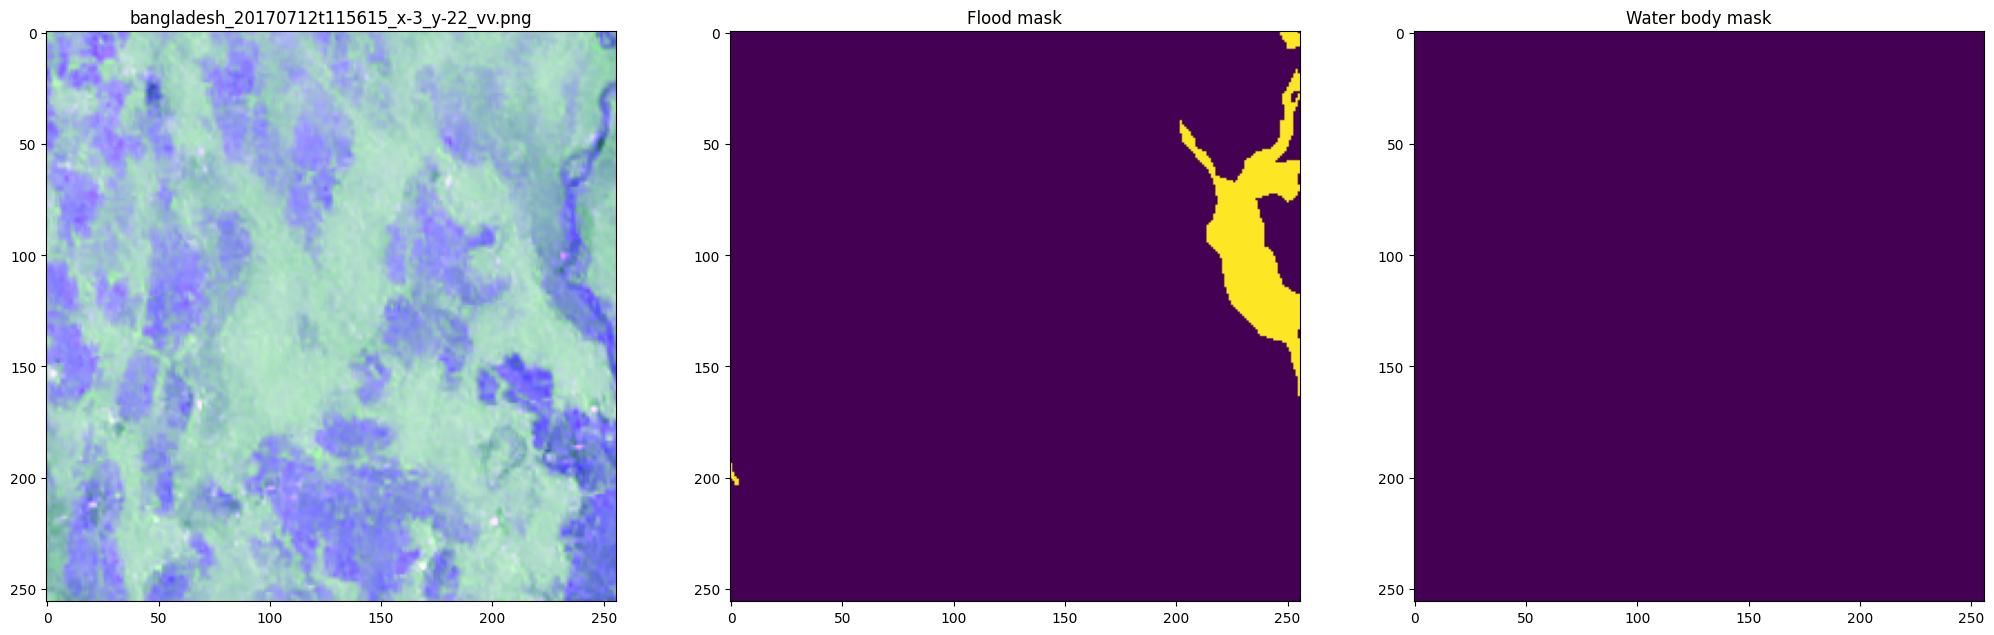

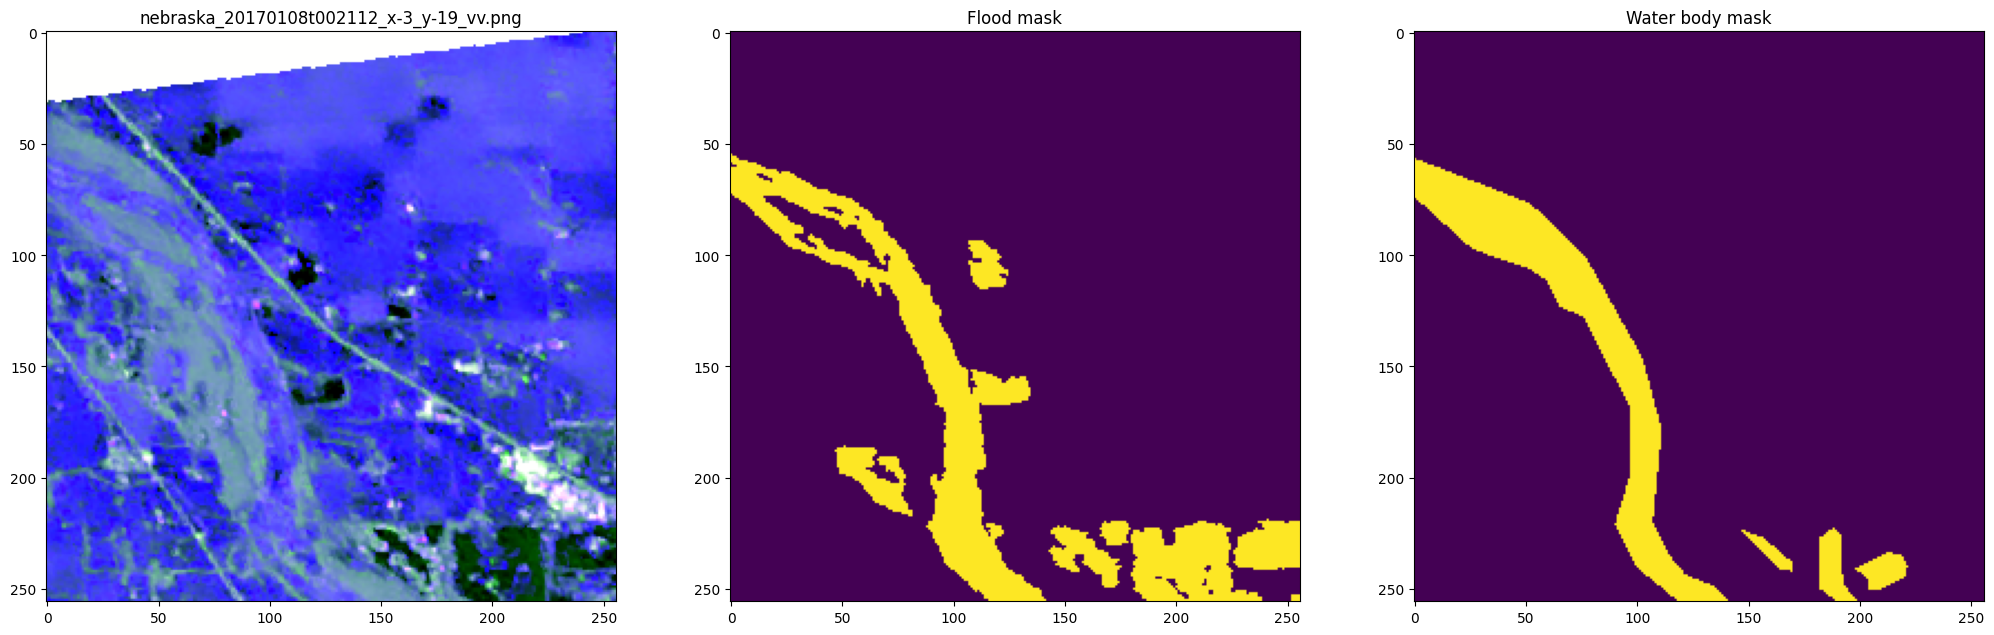

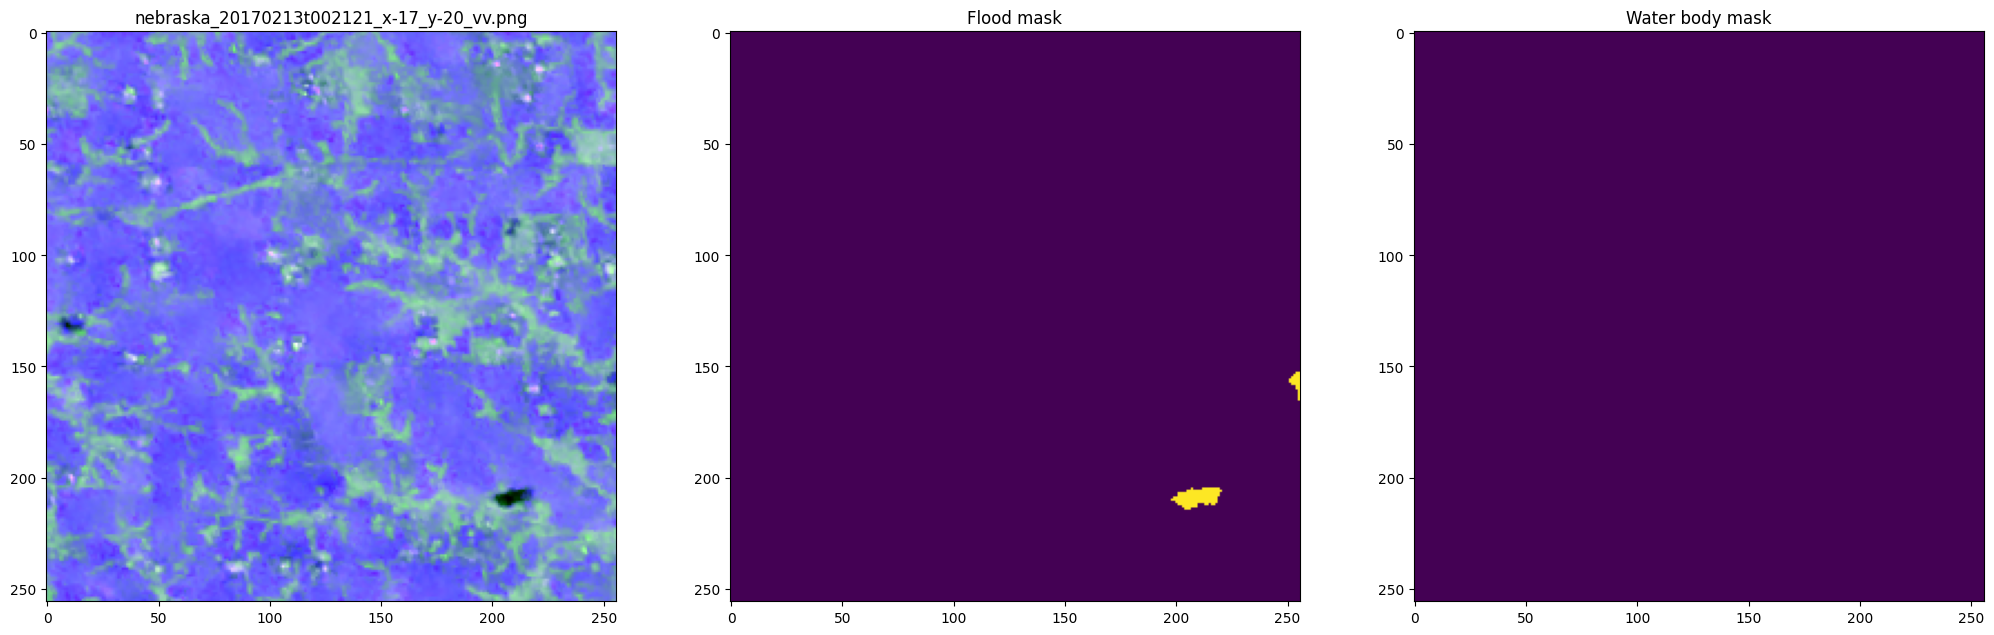

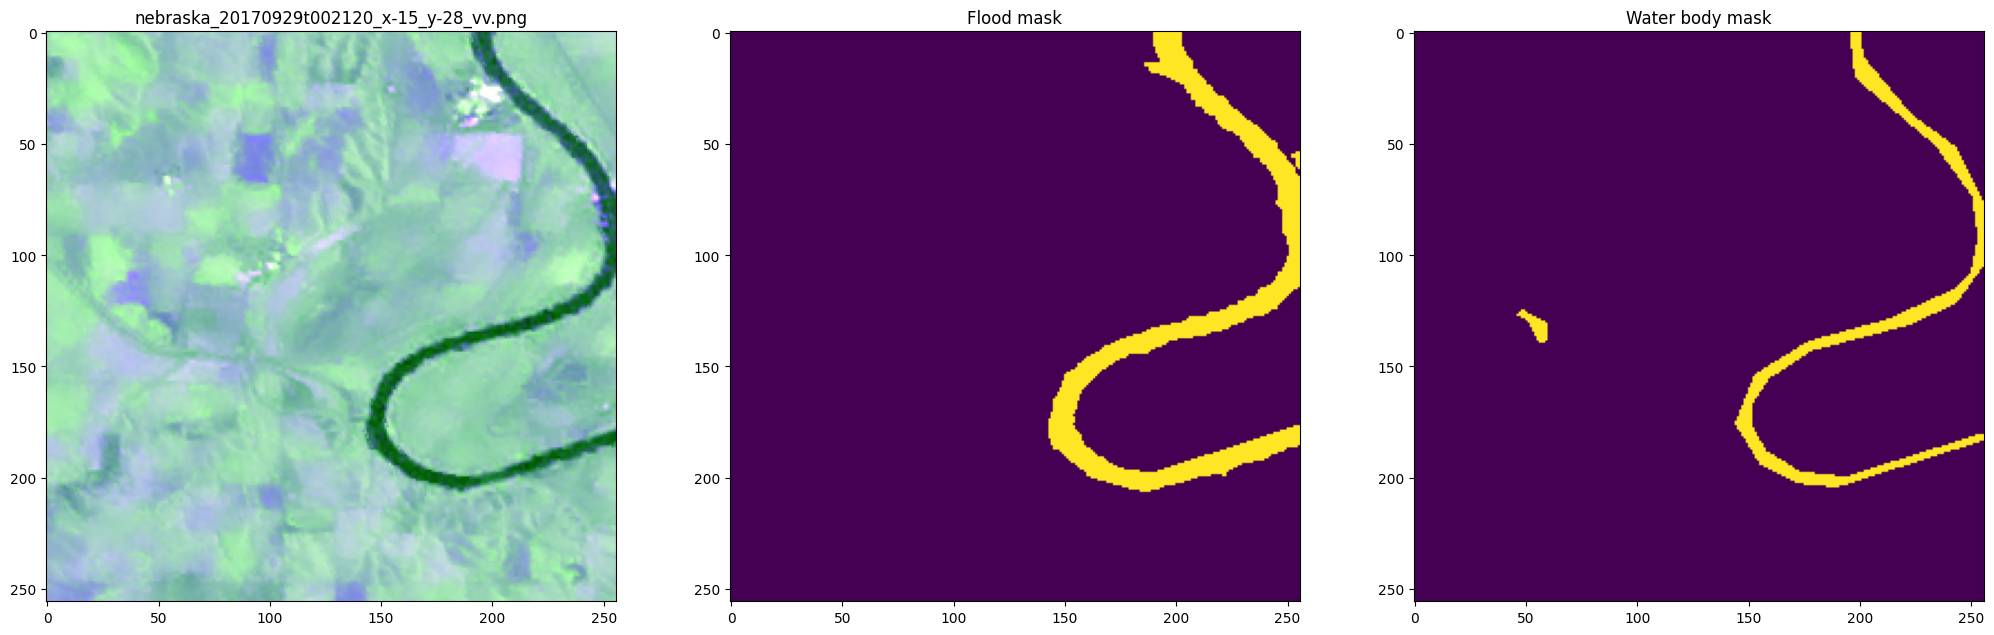

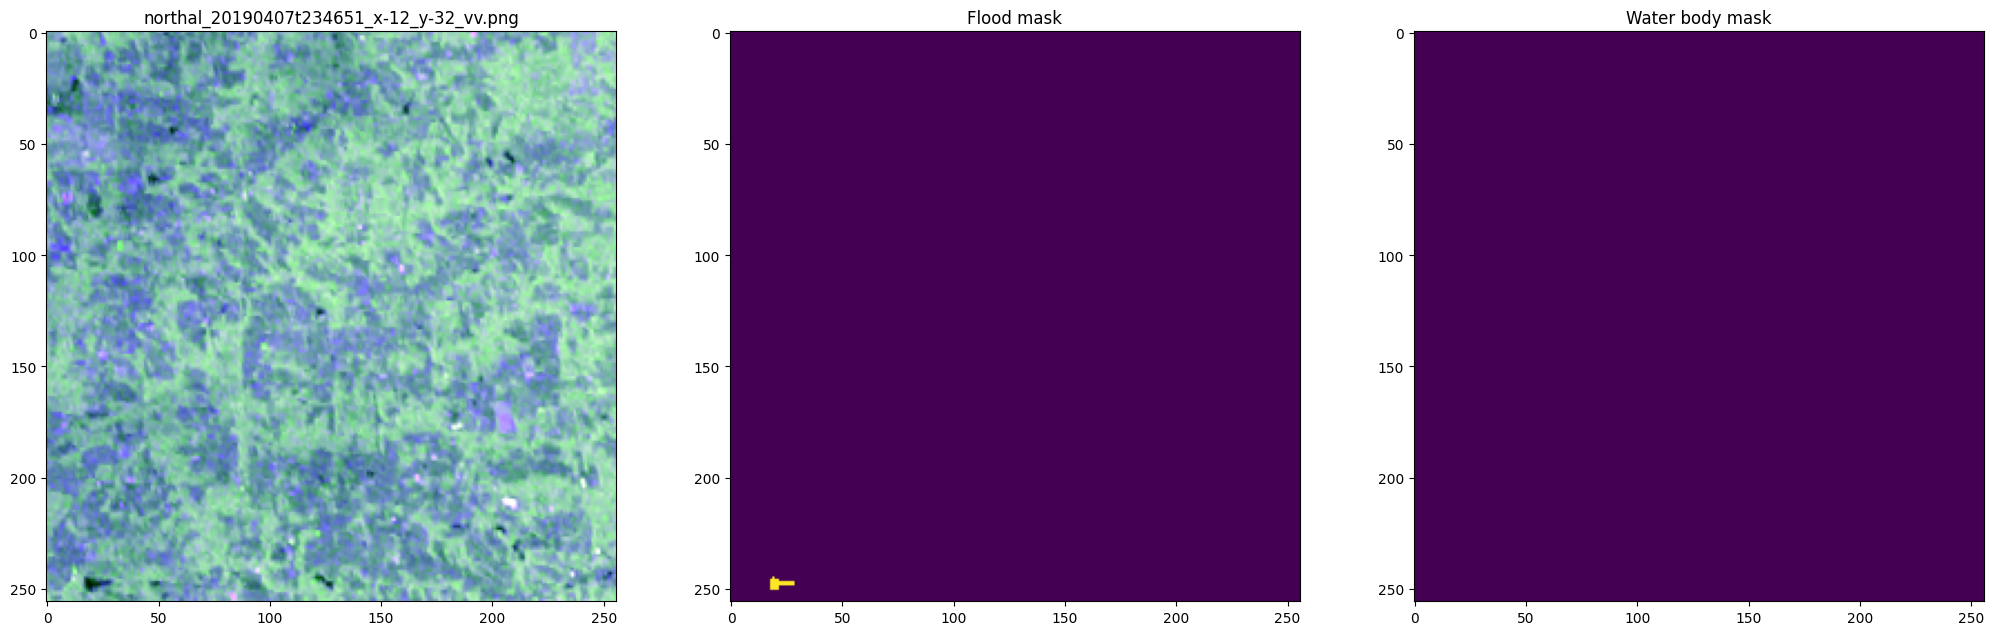

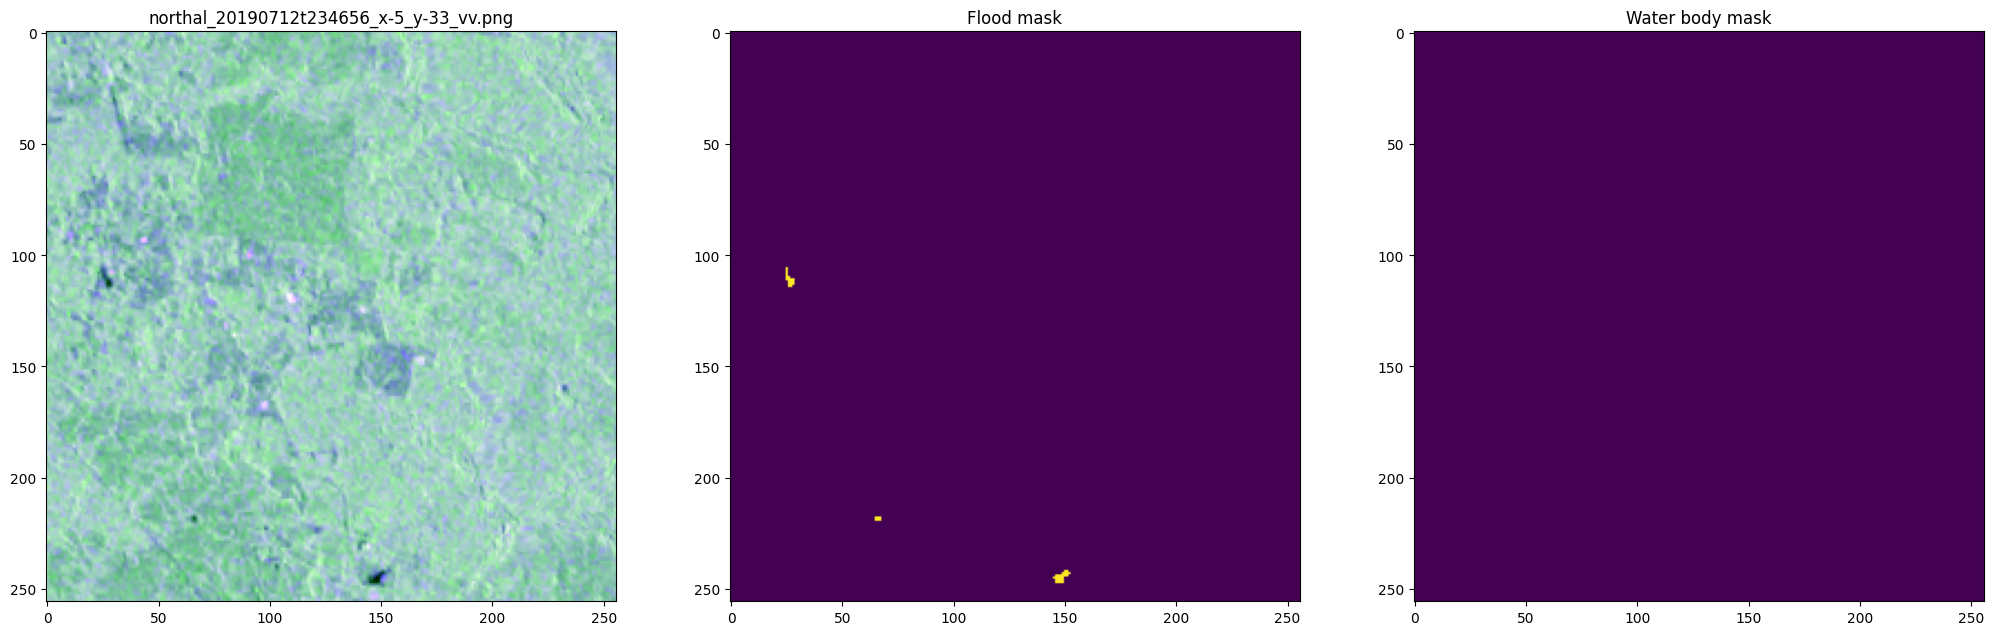

In [17]:
for index in training_images_index:
    visualize(train_df_undersample.iloc[index])    

In [16]:
def analyze_flood_images(flood_image_paths: List[str]) -> None:
    """
    Analyze flood images to count water and background pixels and tiles.

    Args:
        flood_image_paths: List of flood image paths.

    Returns:
       total_water_pixels: Total number of water pixels.
       total_background_pixels: Total number of background pixels.
       total_water_tiles: Total number of water tiles.
       total_background_tiles: Total number of background tiles.
    
    Raises:
        AssertionError: An assertion error occurred while processing the image.
        Exception: An error occurred while processing the image.
    """
    total_water_pixels = 0
    total_background_pixels = 0
    total_water_tiles = 0
    total_background_tiles = 0

    for filename in tqdm(flood_image_paths, desc="Analyzing flood images"):
        try:
            img = mpimg.imread(filename)
            assert np.shape(img) == (256, 256, 3), f"Image shape is not (256, 256, 3): {filename}"
            
            water_pixels = np.sum(img[:, :, 0])  # No need to divide by 255 since we are using mpimg.imread()
            total_water_pixels += water_pixels
            total_background_pixels += 65536 - water_pixels  # 256 * 256 = 65536

            if water_pixels > 0:
                total_water_tiles += 1
            else:
                total_background_tiles += 1

        except AssertionError as e:
            print(e)
        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")
            
    print(f"Total water pixels: {int(total_water_pixels):,}")
    print(f"Total background pixels: {int(total_background_pixels):,}")
    print("Total water tiles:", total_water_tiles)
    print("Total background tiles:", total_background_tiles)
    return total_water_pixels, total_background_pixels, total_water_tiles, total_background_tiles

flood_image_paths = train_df_undersample['flood_label_path'].tolist()

total_water_pixels, total_background_pixels, total_water_tiles, total_background_tiles = analyze_flood_images(flood_image_paths)

Analyzing flood images:   0%|          | 0/9630 [00:00<?, ?it/s]

Total water pixels: 30,020,578
Total background pixels: 601,093,248
Total water tiles: 8374
Total background tiles: 1256


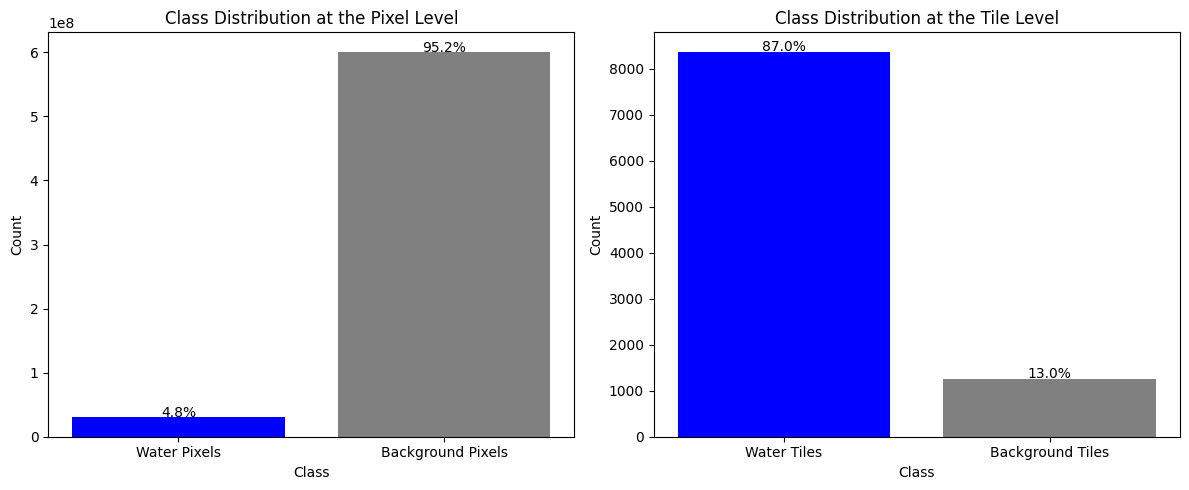

In [17]:
# Data for pixel-level distribution
pixel_classes = ['Water Pixels', 'Background Pixels']
pixel_counts = [total_water_pixels, total_background_pixels]  
pixel_total = sum(pixel_counts)
pixel_percentages = [(count / pixel_total) * 100 for count in pixel_counts]

# Data for tile-level distribution
tile_classes = ['Water Tiles', 'Background Tiles']
tile_counts = [total_water_tiles, total_background_tiles]
tile_total = sum(tile_counts)
tile_percentages = [(count / tile_total) * 100 for count in tile_counts]

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Pixel-level chart ---
axes[0].bar(pixel_classes, pixel_counts, color=['blue', 'gray'])
axes[0].set_title('Class Distribution at the Pixel Level')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
for i, count in enumerate(pixel_counts):
    axes[0].text(i, count + 10, f"{pixel_percentages[i]:.1f}%", ha='center')

# --- Tile-level chart ---
axes[1].bar(tile_classes, tile_counts, color=['blue', 'gray'])
axes[1].set_title('Class Distribution at the Tile Level')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
for i, count in enumerate(tile_counts):
    axes[1].text(i, count + 10, f"{tile_percentages[i]:.1f}%", ha='center')

# Adjust layout and show
plt.tight_layout()
plt.show()

# Step 4: Setup the dataset for machine learning

Since the Phase 1 (Development phase) of the ETCI 2021 Competition on Flood Detection provided with training data (which includes reference data) and a validation data (without reference data until phase 1 concludes),we will split our training dataset (that contains flood masks) into a smaller training and development set. 


### Create a PyTorch dataset

We will be using the PyTorch deep learning library to format this dataset and create our machine learning model. Therefore we will need to create a custom Dataset class and pass it into a DataLoader object (see the [PyTorch Dataset Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)  for more detail on the topic). To compute image transformations we will use the [Albumentations](https://github.com/albumentations-team/albumentations) package. 

In [18]:
class ETCIDataset(Dataset):  # Inherits from the Pytorch Dataset class 
    def __init__(self, dataframe, split, transform=None):
        self.split = split
        self.dataset = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]


    def __getitem__(self, index):
        example = {}
        
        df_row = self.dataset.iloc[index]

        # load vv and vh images and normalize
        vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
        vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
        
        # convert vv and vh images to rgb
        rgb_image = s1_to_rgb(vv_image, vh_image)

        if self.split == 'test':  # If the split is part of the test, it only loads and returns the images, without masks
            # no flood mask should be available
            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')  #HWC->CHW
        else:  # If the split is part of the training set, load images and flood masks and (if set) applies transformations 
            # load ground truth flood mask
            flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

            # compute transformations
            
            if self.transform:
                augmented = self.transform(image=rgb_image, mask=flood_mask)
                rgb_image = augmented['image']
                flood_mask = augmented['mask']

            # Converts to float32 for images, int64 for masks
            example['image'] = rgb_image.transpose((2,0,1)).astype('float32') # Transpose images from HWC (Height, Width, Channels)-> CHW (Channels, Height, Width)
            example['mask'] = flood_mask.astype('int64')

        return example

**2) Check the [Albumentations](https://github.com/albumentations-team/albumentations) package (documentation can be found [here](https://albumentations.ai/docs/) and API reference [here](https://albumentations.ai/docs/api-reference/)) and implement both Vertical and Horizontal flip with probability 0.5 and RandomResizedCrop of 256 on both dimentions. Then load the train and validation set.**

In [ ]:
### BEGINNING OF THE CODE
# Create transformation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),    # Vertical flip with 50% probability
    A.RandomResizedCrop(size = (256, 256))  # Random crop on height and width dimensions and resize to 256x256
])

# Create datasets with and without transformations
train_dataset = ETCIDataset(train_df, split='train', transform=transform)
train_undersampled_dataset = ETCIDataset(train_df_undersample, split='train', transform=transform)
valid_dataset = ETCIDataset(valid_df, split='train', transform=None)  # No transformations for validation

####END OF THE CODE
print('Trainining set size:',len(train_dataset))
print('Undersampled training set size:',len(train_undersampled_dataset))
print('Validation set size:',len(valid_dataset))

Trainining set size: 21771
Undersampled training set size: 9623
Validation set size: 5443


In [ ]:
batch_size = 64  # With a batch size of 64, the training loads up to 8GB of VRAM (can execute only this for steps 6 to avoid memory issues)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Load only the images for the undersampling training (can execute only this for steps 7 and 8 to avoid memory issues)

batch_size = 64  # With a batch size of 64, the training loads up to 8GB of VRAM

# Apply the same transformations to the undersampled dataset, and load the data into a DataLoader object from Pytorch
train_undersampled_loader = DataLoader(train_undersampled_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Step 5: Deep learning model creation

### Select hardware to train model

In [23]:
device = 'cuda' 

**3) Read carefully the documentation of the segmentation model from the [Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch) package ([documentation here](https://smp.readthedocs.io/en/latest/)),  implement a UNet with resnet34 as encoder, without any pre-trained weights, and the appropriate number of in_channel and classes based on the dataset.**

In [24]:
def create_model():
    ###CODE HERE
    # Create a UNet model with ResNet34 encoder
    model = smp.Unet(  # Load model from segmentation models for Pytorch
        encoder_name="resnet34",  # Use ResNet34 as backbone
        encoder_weights=None,  # Don't use pre-trained weights
        in_channels=3,  # Input has 3 channels (RGB representation of VV, VH, and ratio)
        classes=2,  # Binary segmentation (flood vs non-flood)
        activation=None  # No activation to apply after the final convolutional layer - using CrossEntropyLoss which expects raw logits
    )
    return model

In [26]:
model_1 = create_model()
model_1.to(device) # load model into GPU memory

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Metric tracker

In [ ]:
class EvalTracker:
    def __init__(self, n_classes=2, smooth=0.0001):
        self.n_classes = n_classes
        self.reset()
        self.smooth = smooth

    def reset(self):
        self.cm = np.zeros((self.n_classes, self.n_classes))
        self.count = 0
    
    def update(self, pred, target):
        # pred: [B, 2, H, W]
        # target: [B, H, W]
        self.count += pred.shape[0]

        # reshape inputs
        pred = pred.argmax(dim=1).flatten()  # [B*H*W]
        target = target.flatten()  # [B*H*W]

        # put into cpu memory
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()

        # compute confusion matrix values
        self.cm += confusion_matrix(target, pred)

    def get_mean(self):
        tn, fp, fn, tp = self.cm.ravel()

        # compute IoU (intersection over union)
        iou = tp / (tp + fp + fn + self.smooth)
        prec = tp / (tp + fp + self.smooth)
        rec = tp / (tp + fn + self.smooth)
        f1 = 2.0*prec*rec/(prec+rec)

        return iou, prec, rec, f1

# Step 6: Train model on the full dataset

### Model config, optimizer and loss function

In [28]:
# set the number of times you want the model to see all of the training data
epochs = 15
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
criteria_no_weights = nn.CrossEntropyLoss(weight=None)

### Training loop

In [29]:
train_loss_dict={}
val_loss_dict={}
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_loader)
    train_loss = 0.0
    model_1.train()
    eval_logger = EvalTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)

        # pass images into model
        pred = model_1(image)

        # get loss
        loss = criteria_no_weights(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
               
        # compute and display progress
        eval_logger.update(pred, mask)
        mIoU, Prec, Rec, f1 = eval_logger.get_mean()
        pbar.set_description('Training Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
        train_loss += loss.item() * image.size(0)
    # calculate the average loss for both training and validation
    train_loss /= len(train_loader.dataset)
    train_loss_dict[epoch] = train_loss
        
    # valid set
    pbar = tqdm(valid_loader)
    model_1.eval()
    eval_logger = EvalTracker()
    val_loss = 0.0
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model_1(image)

            # get loss
            loss = criteria_no_weights(pred, mask)
                       
            # compute and display progress
            eval_logger.update(pred, mask)
            mIoU, Prec, Rec, f1 = eval_logger.get_mean()
            pbar.set_description('Validation Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
            val_loss += loss.item() * image.size(0)
    val_loss /= len(valid_loader.dataset)
    val_loss_dict[epoch] = val_loss
    
# Save the training loss values
with open(f'./loss/train_loss_1_BCE_epochs_{epochs}.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
     
# Save the validation loss values
with open(f'./loss/val_loss_1_BCE_epochs_{epochs}.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)            
# save model
torch.save(model_1.state_dict(), f'./models/model_1_BCE_epochs_{epochs}.pt')

Epoch: [1/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [2/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [3/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [4/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [5/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [6/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [7/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [8/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [9/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [10/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [11/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [12/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [13/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [14/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [15/15]


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

### Plot Losses

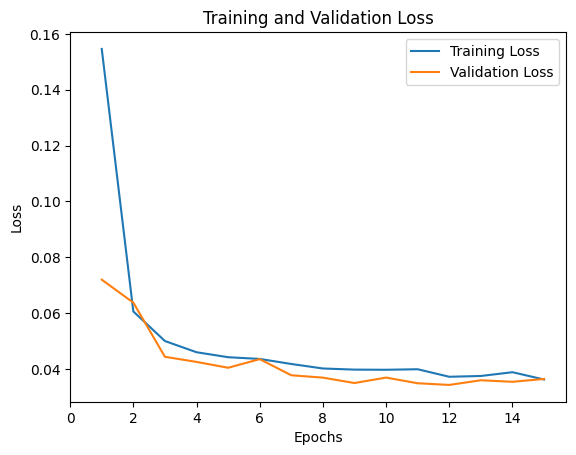

In [35]:
# Load the training and validation loss dictionaries
train_loss = load(open(f'./loss/train_loss_1_BCE_epochs_{epochs}.pkl', 'rb'))
val_loss = load(open(f'./loss/val_loss_1_BCE_epochs_{epochs}.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Saving the metrics

In [31]:
# Evaluate the model to recalculate metrics
def evaluate_model(model_path, data_loader, device='cuda'):
    # Load the model
    model = create_model()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    # Initialize metric tracker
    eval_logger = EvalTracker()
    
    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Load data
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
            
            # Forward pass
            pred = model(image)
            
            # Update metrics
            eval_logger.update(pred, mask)
    
    # Get final metrics
    mIoU, Prec, Rec, f1 = eval_logger.get_mean()
    
    print(f"Model: {model_path}")
    print(f"IoU: {mIoU:.4f}")
    print(f"Precision: {Prec:.4f}")
    print(f"Recall: {Rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {'iou': mIoU, 'precision': Prec, 'recall': Rec, 'f1': f1}

# Evaluate the model on the validation set and save model metrics
def save_model_metrics(model_path, data_loader, save_path=None, device='cuda'):
    """
    Evaluate a model and save its performance metrics to a file
    
    Args:
        model_path: Path to the saved model
        data_loader: DataLoader with validation/test data
        save_path: Where to save the metrics (default: derived from model path)
        device: Device to run evaluation on
    """
    # If no save path provided, create one based on the model path
    if save_path is None:
        model_filename = os.path.basename(model_path)
        model_name = os.path.splitext(model_filename)[0]  # Remove .pt extension
        save_path = f'./metrics/{model_name}_metrics.pkl'
    
    # Make sure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Evaluate the model
    metrics = evaluate_model(model_path, data_loader, device)
    
    # Save the metrics
    with open(save_path, 'wb') as file:
        pickle.dump(metrics, file)
    
    print(f"Metrics saved to {save_path}")
    return metrics

In [ ]:
# Recalculate, show and save metrics for evaluation set, model 1
metrics_1 = save_model_metrics(
    model_path='./models/model_1_BCE_epochs_15.pt',
    data_loader=valid_loader
)

  0%|          | 0/86 [00:00<?, ?it/s]

Model: ./models/model_1_BCE_epochs_15.pt
IoU: 0.5980
Precision: 0.8779
Recall: 0.6523
F1 Score: 0.7484
Metrics saved to ./metrics/model_1_BCE_epochs_15_metrics.pkl


# Step 7: Train model on the undersampled dataset

### Model config, optimizer and loss function

In [40]:
model_2 = create_model()
model_2.to(device)
epochs = 15
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
criteria_no_weights = nn.CrossEntropyLoss(weight=None)

In [48]:
# Free up memory by deleting the DataLoader object for the full training set
if 'train_loader' in locals() or 'train_loader' in globals():
    del train_loader
    import gc
    gc.collect()
    torch.cuda.empty_cache()

**4) Implement a training loop similar to the one above but for the undersampled dataset. Use model_2 to avoid any overwriting of the previous model. Save the model as 'model_2d_BCE.pt'***

### Training loop

In [41]:
### CODE HERE###
train_loss_dict={}
val_loss_dict={}
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_undersampled_loader)  # Undersampled loader
    train_loss = 0.0
    model_2.train()  # Set to training mode
    eval_logger = EvalTracker()
    for batch in pbar:  # Batch size set above
        # load image and mask into device memory
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)

        # pass images into model
        pred = model_2(image)

        # get loss
        loss = criteria_no_weights(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
               
        # compute and display progress
        eval_logger.update(pred, mask)
        mIoU, Prec, Rec, f1 = eval_logger.get_mean()
        pbar.set_description('Training Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
        train_loss += loss.item() * image.size(0)
    # calculate the average loss for both training and validation
    train_loss /= len(train_undersampled_loader.dataset)  # Compute average loss for the training undersampled dataset
    train_loss_dict[epoch] = train_loss
        
    # valid set
    pbar = tqdm(valid_loader)  # Validation loader
    model_2.eval()  # Set to evaluation mode (faster)
    eval_logger = EvalTracker()
    val_loss = 0.0
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model_2(image)

            # get loss
            loss = criteria_no_weights(pred, mask)
                       
            # compute and display progress
            eval_logger.update(pred, mask)
            mIoU, Prec, Rec, f1 = eval_logger.get_mean()
            pbar.set_description('Validation Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
            val_loss += loss.item() * image.size(0)
    val_loss /= len(valid_loader.dataset)
    val_loss_dict[epoch] = val_loss
    
# Save the training loss values
with open(f'./loss/train_loss_2d_BCE_epochs_{epochs}.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
     
# Save the validation loss values
with open(f'./loss/val_loss_2d_BCE_epochs_{epochs}.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)            
# save model
torch.save(model_2.state_dict(), f'./models/model_2d_BCE_epochs_{epochs}.pt')

Epoch: [1/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [2/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [3/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [4/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [5/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [6/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [7/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [8/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [9/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [10/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [11/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [12/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [13/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [14/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [15/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

In [42]:
train_path =r'train_df.csv'
valid_path = r'valid_df.csv'
train_under_path = r'train_df_undersample.csv'
train_df.to_csv(train_path)
valid_df.to_csv(valid_path)
train_df_undersample.to_csv(train_under_path)

### Plot Losses

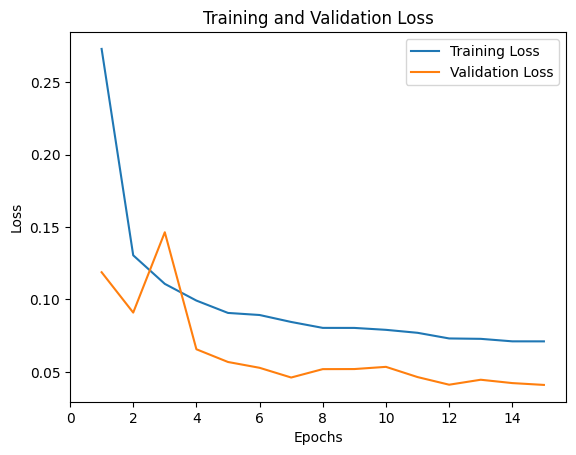

In [43]:
# Load the training and validation loss dictionaries
train_loss = load(open(f'./loss/train_loss_2d_BCE_epochs_{epochs}.pkl', 'rb'))
val_loss = load(open(f'./loss/val_loss_2d_BCE_epochs_{epochs}.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Saving the metrics

In [44]:
# Recalculate, show and save metrics for evaluation set, model 2
metrics_2 = save_model_metrics(
    model_path='./models/model_2d_BCE_epochs_15.pt',
    data_loader=valid_loader
)

  0%|          | 0/86 [00:00<?, ?it/s]

Model: ./models/model_2d_BCE_epochs_15.pt
IoU: 0.5632
Precision: 0.9027
Recall: 0.5997
F1 Score: 0.7206
Metrics saved to ./metrics/model_2d_BCE_epochs_15_metrics.pkl


# Step 8: Train model on the undersampled dataset with a weighted loss function

### Defining the split for the weighted Cross Entropy Loss

In [26]:
#It take quite a long time to calculate, the ratio is around 5% flooded pixels, 95% background (see also the end of step 4)
n_size = len(flood_label_paths_train_undersampled)  # Number of images in the undersampled training set 
n_flooded = np.ndarray((n_size,),)  # Initialize an array with as many elements as images in the undersampled training set 

for i in tqdm(range(n_size)):  # Loop as many times as the number of flooded images
    flood_label=cv2.imread(flood_label_paths_train_undersampled[i], 0)  # Read each flood mask image
    n_flooded[i] = np.sum(flood_label)/255  # Update the array with the sum of (normalized) pixels corresponding to flood (255, 0 for background)

n_flooded_ratio = np.divide(n_flooded,256*256)  # Ratio of the number of pixels corresponding to flood over the total number of pixels per mask
flooded_pixels = np.sum(n_flooded)  # Total number of flooded pixels
background_pixels = 256*256*n_size-np.sum(n_flooded)  # Total number of background pixels
print("Flooded Pixels:", flooded_pixels)
print("Background Pixels:", background_pixels)
print("Ratio:", np.mean(n_flooded_ratio))

  0%|          | 0/9623 [00:00<?, ?it/s]

Flooded Pixels: 29984090.0
Background Pixels: 600668838.0
Ratio: 0.04754451881336544


### Model config, optimizer and loss function

**5) Define the "Model config, optimizer and loss function" section as previously done but for "model_3" which will be trained with a [Weighted Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Remember to store the weights as a torch tensor, to load it in the GPU, and be careful on the order of your weights.**

In [27]:
###CODE HERE

# Calculate weights based on class imbalance
background_weight = 1.0
flood_weight = 1 / np.mean(n_flooded_ratio)  # mean inverse class frequency ratio

# Create weights tensor and move to GPU
weights = torch.tensor([background_weight, flood_weight], dtype=torch.float32).to(device)

# Define model, optimizer and weighted loss function
model_3 = create_model()
model_3.to(device)
epochs = 15
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)
criteria_weights = nn.CrossEntropyLoss(weight=weights)

**6) Why did you choose the weights you used for the CrossEntropyLoss?**

We have set a higher weight to the minority class (pixels denoting flood) in order that the **model penalizes more heavily missclassified flood pixels**, which will help it "focus" more on getting the minority class right during training. To do so, we have simply assigned a weight of 1 to the background pixels (the same weight as they had without having assigned weights to the loss), but the flooded pixels are upweighted through the inverse of the average ratio of flood pixels in the undersampled dataset. 

### Training Loop

In [28]:
train_loss_dict={}
val_loss_dict={}
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_undersampled_loader)
    train_loss = 0.0
    model_3.train()
    eval_logger = EvalTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)

        # pass images into model
        pred = model_3(image)

        # get loss
        loss = criteria_weights(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute and display progress
        eval_logger.update(pred, mask)
        mIoU, Prec, Rec, f1 = eval_logger.get_mean()
        pbar.set_description('Training Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
        train_loss += loss.item() * image.size(0)
    # calculate the average loss for both training and validation
    train_loss /= len(train_undersampled_loader.dataset)
    train_loss_dict[epoch] = train_loss
    # valid set
    pbar = tqdm(valid_loader)
    val_loss = 0.0
    model_3.eval()
    eval_logger = EvalTracker()
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model_3(image)

            # get loss
            loss = criteria_weights(pred, mask)
            
            # compute and display progress
            eval_logger.update(pred, mask)
            mIoU, Prec, Rec, f1 = eval_logger.get_mean()
            pbar.set_description('Validation Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
            val_loss += loss.item() * image.size(0)
    val_loss /= len(valid_loader.dataset)
    val_loss_dict[epoch] = val_loss
    
# Save the training loss values
with open(f'./loss/train_loss_2d_WBCE_epochs_{epochs}.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
     
# Save the validation loss values
with open(f'./loss/val_loss_2d_WBCE_epochs_{epochs}.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)   
# save model
torch.save(model_3.state_dict(), f'./models/model_2d_WBCE_epochs_{epochs}.pt')

Epoch: [1/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [2/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [3/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [4/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [5/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [6/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [7/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [8/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [9/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [10/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [11/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [12/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [13/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [14/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Epoch: [15/15]


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

### Plot Losses

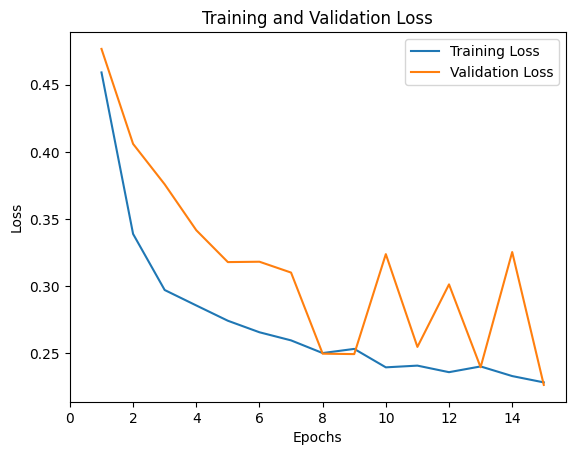

In [29]:
# Load the training and validation loss dictionaries
train_loss = load(open(f'./loss/train_loss_2d_WBCE_epochs_{epochs}.pkl', 'rb'))
val_loss = load(open(f'./loss/val_loss_2d_WBCE_epochs_{epochs}.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Saving the metrics

In [32]:
# Recalculate, show and save metrics for evaluation set, model 3
metrics_3 = save_model_metrics(
    model_path='./models/model_2d_WBCE_epochs_15.pt',
    data_loader=valid_loader
)

  0%|          | 0/86 [00:00<?, ?it/s]

Model: ./models/model_2d_WBCE_epochs_15.pt
IoU: 0.1572
Precision: 0.1596
Recall: 0.9119
F1 Score: 0.2716
Metrics saved to ./metrics/model_2d_WBCE_epochs_15_metrics.pkl


**7) How are the three models (model_1_BCE.pt, model_2d_BCE.pt, and model_2d_WBCE.pt) performning? Comment the performances of the models.**

In [33]:
# First, we need to check the metrics of the model on the validation set
def load_metrics(metrics_path):
    """Load metrics from a pickle file"""
    with open(metrics_path, 'rb') as file:
        return pickle.load(file)

In [35]:
# Load metrics for comparison
model1_metrics = load_metrics('./metrics/model_1_BCE_epochs_15_metrics.pkl')
model2_metrics = load_metrics('./metrics/model_2d_BCE_epochs_15_metrics.pkl')
model3_metrics = load_metrics('./metrics/model_2d_WBCE_epochs_15_metrics.pkl')

# Create a comparison table
df_comparison = pd.DataFrame([
    model1_metrics,
    model2_metrics, 
    model3_metrics
], index=['Full dataset', 'Undersampled', 'Undersampled and Weighted BCE'])

display(df_comparison)

iou  precision    recall        f1
Full dataset                   0.598009   0.877898  0.652260  0.748442
Undersampled                   0.563245   0.902698  0.599651  0.720610
Undersampled and Weighted BCE  0.157170   0.159592  0.911945  0.271645

Explanation of the results through the different metrics:

- **Intersection over Union (IoU)**: IoU is a metric that measures the overlap between the predicted segmentation mask and the ground-truth mask, with a value of 1 representing a complete overlap between both masks. In this case, the model trained with the full dataset is the one that achieves a highest value, which can be possibly attributed to a better balance between the number of false positives (as represented by the precision) and the number of false negatives (as represented by the recall), compared to the other methods.
- **Precision**: rate of correct predictions of the positive class (flooded + water body area) over all positive predictions. In this case, the model with undersampling but a non-weighted cross-entropy loss manages to get the highest precision, presumably since, in relative terms, it is able to learn more from pixels corresponding to the positive class (and, thus, assign less often a background pixel as a water pixel). The model with the weighted BCE completely fails in this metric, possibly because it ends up giving too much relevance to find pixels corresponding to the positive class.
- **Recall**: rate of true positives over all positive instances (TP + FN). The first 2 models manage to get a good trade-off between precision and recall, but the latter is lower for both models as they possibly tend to underpredict the positive class. This is improved through the weighted cross-entropy loss, which makes the model prioritize avoiding to predict positive pixels. However, the precision cost in this case is too high, which could lead us to choose instead lower weights for the positive class (so that precision does not fall as much).
- **F1-score**: harmonic mean of precision and recall. The first model manages to get the highest F1-score, by managing a good balance between precision and recall.

The best model overall depends, of course, on the priorities that are set for a specific application (e.g., ensuring the prediction of flooded areas or avoiding false positives). In this case, the last model (undersampling and weighted cross-entropy) can be said to sacrifice too much precision for a (considerably) higher recall. And between the first two models, the first one (with the full dataset) probably achieves a better balance betweeen false positives and false negatives overall.

# Step 9a (Optional): Train more models
Feel free to train mode model changing the configuration, learning rate, optimizer, loss function, etc. This is fully optional and bonus points will be assigned to go beyond the max grade. Total freedom here to create #Step 9b, 9c, etc.. Rememebr that this is 100% optional and won't influence your grading, it is a space to experiment ideas. I suggest you finalize the notebook first given the limited computational resources and get back to this later. 

Please add in the text cell below the idea behind the experiment you are about to run. Why do you want to test that specific conifguration? What do you expect in terms of results and what did you get after training? 

In [ ]:
### CREATE A TEXT CELL BELOW AS EXPLAINED ABOVE EXPLAINING YOUR EXPERIMENT

Let's train the second model with transfer learning from Imagenet using imagenet stats

#### Create the dataloader (if needed) and the model (if needed)

In [ ]:
### CODE HERE


### Model config, optimizer and loss function

In [ ]:
###CODE HERE


### Training Loop

In [ ]:
### CODE HERE

### Plot Losses

In [ ]:
### CODE HERE


# Step 10: Test models

### Create a test dataset
Let's create Dataset and DataLoader objects for the validation set. This time we will not have labels.

In [37]:
vv_image_paths = sorted(glob(test_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]

vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(test_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path ()
    flood_label_paths.append(np.nan)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(test_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)

test_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}

test_df = pd.DataFrame(valid_paths)

print(test_df.shape)
test_df.head()

(5443, 4)


vv_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                       vh_image_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                                    flood_label_path  \
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...   
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...   

                               water_body_label_path  
0  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
1  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
2  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
3  /home/pablo/Documents/BSE-DSDM/3-Applications_...  
4  /home/pablo/Documents/BSE-DSDM/3-Applications_...

In [38]:
# Print some sample paths for the test dataset

test_images_index = [100, 500, 1000, 2000, 4000]

for index in test_images_index:
    print(f'Path to the (undersampled) test image {index}')
    print(test_df.iloc[index]['vv_image_path'])
    print('\n')

Path to the (undersampled) test image 100
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/northal_20190630t234655/tiles/vv/northal_20190630t234655_x-12_y-27_vv.png


Path to the (undersampled) test image 500
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/northal_20191004t234700/tiles/vv/northal_20191004t234700_x-1_y-26_vv.png


Path to the (undersampled) test image 1000
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/northal_20190829t234659/tiles/vv/northal_20190829t234659_x-2_y-23_vv.png


Path to the (undersampled) test image 2000
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/northal_20190302t234651/tiles/vv/northal_20190302t234651_x-20_y-5_vv.png


Path to the (undersampled) test image 4000
/home/pablo/Documents/BSE-DSDM/3-Applications_of_DL/data_hw3/ecti2021/train/train/northal_20190618t234654/tiles/vv/northal_20190618t234654_x-9_y-19_vv.png




In [40]:
# Create test without transformations
test_dataset = ETCIDataset(test_df, split='test', transform=None)  # No transformations for test

print('Test set size:',len(test_dataset))

# Create DataLoader for test dataset
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Test set size: 5443


### Run inference

**8) Choose your best performing model from Steps 6-9 and run inference below:**

In [41]:
# Load the model
model = create_model()
### CODE HERE
model.load_state_dict(torch.load('./models/model_1_BCE_epochs_15.pt'))  # Load model weights for model 1 (full dataset, no undersampling) 
model.to(device)
model.eval()

# Store predictions
final_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # Load data (only images are available)
        image = batch['image'].to(device)
        
        # Forward pass
        pred = model(image)
        
        # Store predictions
        pred_masks = pred.argmax(dim=1).cpu().numpy()
        for i in range(pred_masks.shape[0]):
            final_predictions.append(pred_masks[i])

  0%|          | 0/86 [00:00<?, ?it/s]

### Visualize some results

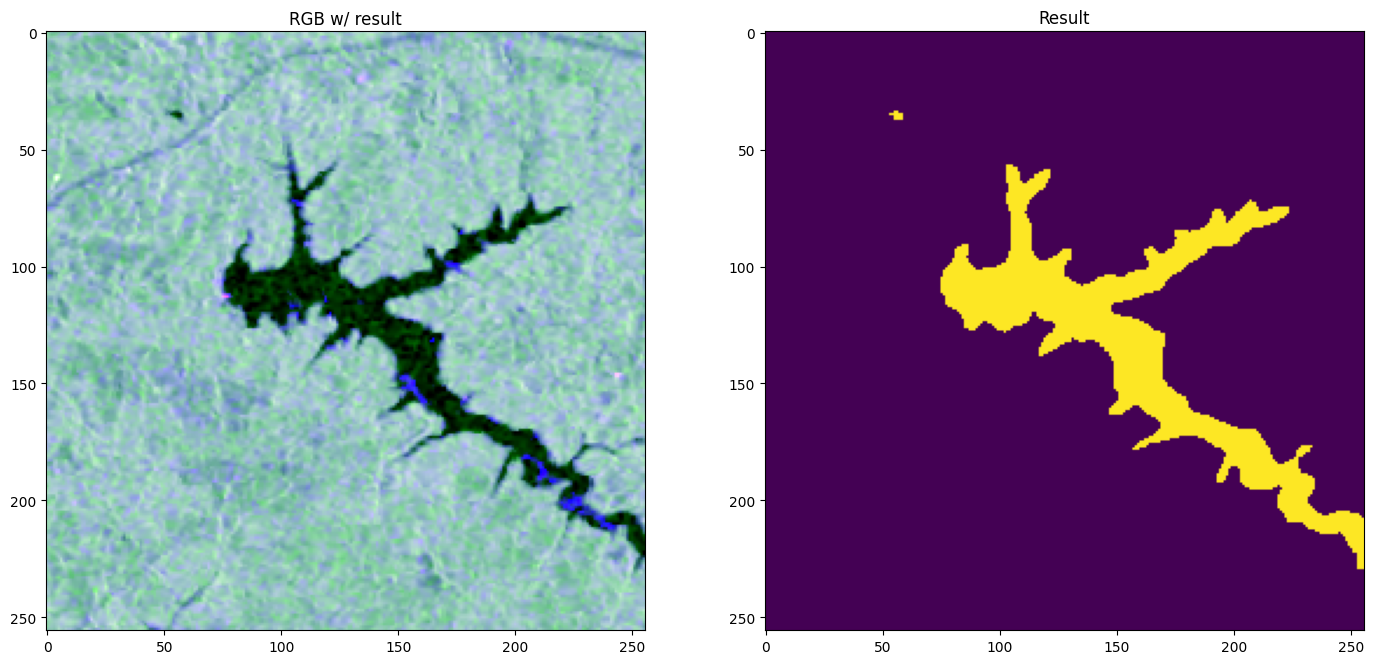

In [42]:
index = 252
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

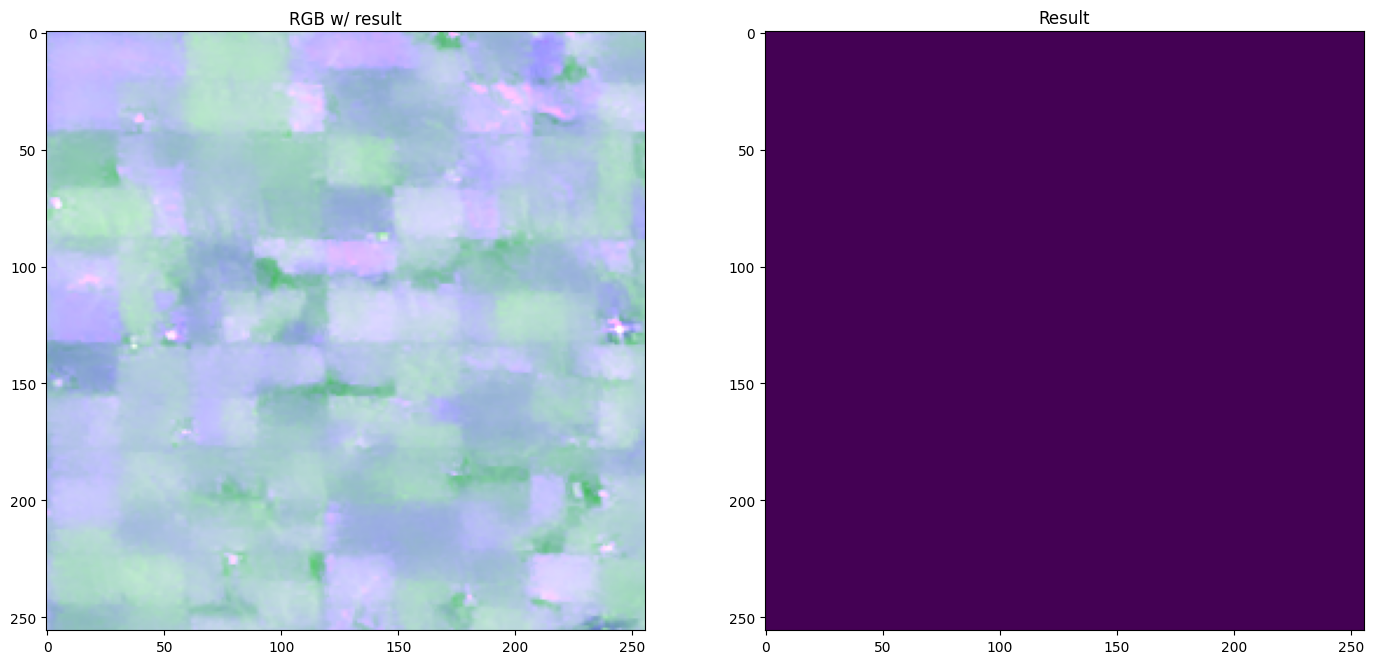

In [43]:
index = -100
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

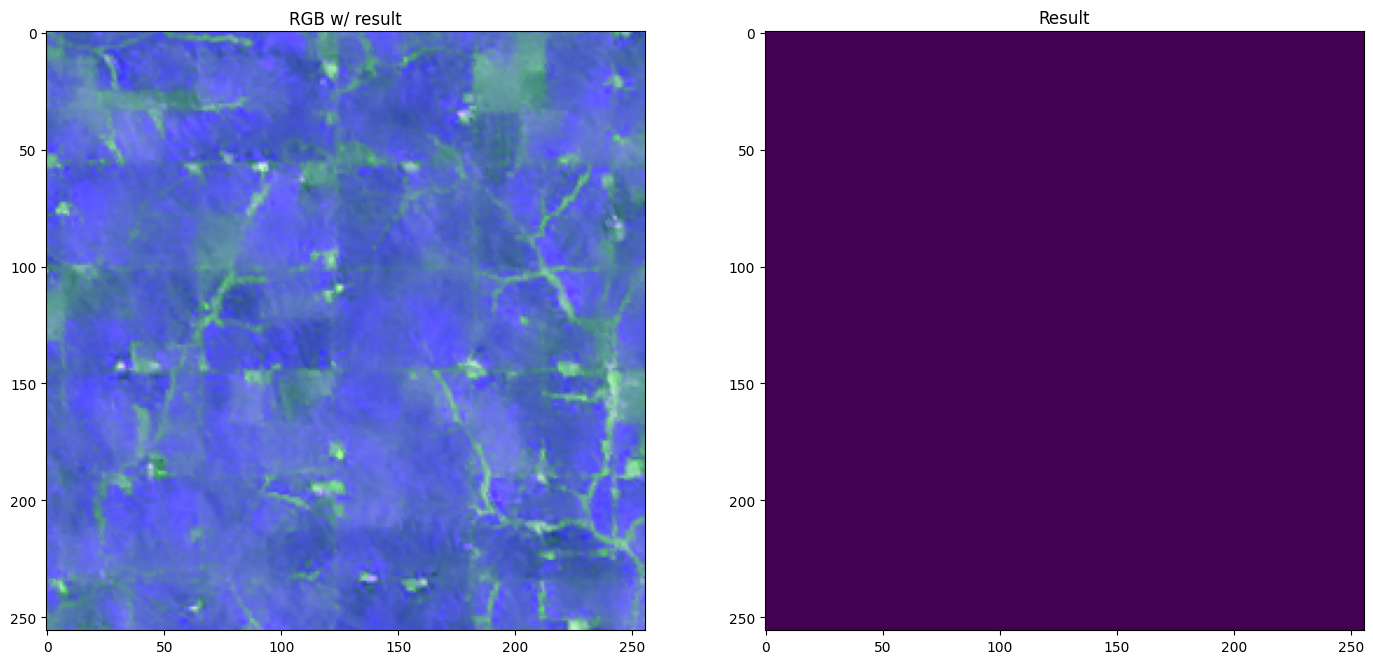

In [44]:
index = 1910
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))